In [44]:
from vivarium import Vivarium
from spatio_flux import PROCESS_DICT, TYPES_DICT

In [45]:
v = Vivarium(processes=PROCESS_DICT, types=TYPES_DICT)

In [46]:
# view the available processes
print('PROCESSES:')
v.print_processes()

PROCESSES:
['MinimalParticle', 'console-emitter', 'ram-emitter', 'DynamicFBA', 'composite', 'Particles', 'DiffusionAdvection']


In [47]:
# inspect the config schema for the 'increase' process
print("CONFIG SCHEMA for 'DynamicFBA' process:")
print(v.process_schema('DynamicFBA'))

CONFIG SCHEMA for 'DynamicFBA' process:
(model_file:string|kinetic_params:map[tuple[float,float]]|substrate_update_reactions:map[string]|biomass_identifier:string|bounds:map[bounds])


In [48]:
# # inspect the process interface (inputs/outputs) for the 'increase' process
# TODO -- this is not working
# print("INTERFACE SCHEMA for 'DynamicFBA' process:")
# print(v.process_interface('DynamicFBA'))

In [49]:
# add a dynamic FBA process called 'dFBA'
v.add_process(name="dFBA",
              process_id="DynamicFBA",
              config={
                "model_file": "textbook",
                "kinetic_params": {
                    "glucose": (0.5, 1),
                    "acetate": (0.5, 2)},
                "substrate_update_reactions": {
                    "glucose": "EX_glc__D_e",
                    "acetate": "EX_ac_e"},
                "biomass_identifier": "biomass",
                "bounds": {
                    "EX_o2_e": {"lower": -2, "upper": None},
                    "ATPM": {"lower": 1, "upper": 1}}},
              )


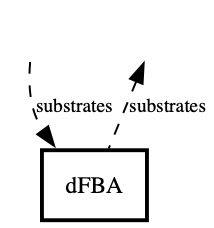

In [50]:
v.diagram(dpi='140')

In [52]:
mol_ids = ["glucose", "acetate", "biomass"]
path=['fields']
i = 0
j = 0

def build_path(mol_id):
    base_path = path + [mol_id]
    if i is not None:
        base_path.append(i)
    if j is not None:
        base_path.append(j)
    return base_path

v.connect_process(
    process_name="dFBA",
    inputs={
            "substrates": {mol_id: build_path(mol_id) for mol_id in mol_ids}
        },
    outputs={
            "substrates": {mol_id: build_path(mol_id) for mol_id in mol_ids}
        }
)
v

Vivarium( 
{ 'dFBA': { 'address': 'local:DynamicFBA',
            'config': { 'biomass_identifier': 'biomass',
                        'bounds': { 'ATPM': {'lower': 1.0, 'upper': 1.0},
                                    'EX_o2_e': {'lower': -2.0, 'upper': None}},
                        'kinetic_params': { 'acetate': (0.5, 2.0),
                                            'glucose': (0.5, 1.0)},
                        'model_file': 'textbook',
                        'substrate_update_reactions': { 'acetate': 'EX_ac_e',
                                                        'glucose': 'EX_glc__D_e'}},
            'inputs': { 'substrates': { 'acetate': ['fields', 'acetate', 0, 0],
                                        'biomass': ['fields', 'biomass', 0, 0],
                                        'glucose': [ 'fields',
                                                     'glucose',
                                                     0,
                                             